# Goal

Datasets:
1. CIFAR-10
2. MNIST

Models:
1. Convolutional Features
2. ReLU Features
3. Fourier Features

Each model transforms the data to a feature matrix $[M_{TM} | M_{TU}]$ where $M_{TM}$ is the data matrix for the training set and $M_{TU}$ are the basis functions that we have not yet modeled. We will compute the best coefficients, $\tilde{c}$ of basis functions to model the labels on the modeled training set and the best coefficients, $c$, of all basis functions to model the labels on the whole training set. We will then compute the error $c_{err} = \tilde{c}-c^*$ where $c^*$ is the truncated version of $c$ to match the size of $\tilde{c}$. We initialize $c$ with the least-squares coefficients learned from the whole training set. Then we compute $\tilde{c}$ by solving the least-squares problem on the sampled training set.

For each dataset, we will:
- Sample the features uniformly at random vs by leverage scores.
- Plot $||A||_2$, $||M_{TM}^+||_2$, and $||\tilde{c}-c^*||_2$ for the sampled features as a function of the number of sampled points.

We expect to see that leverage score sampling leads to a smaller error $||\tilde{c}-c^*||_2$ for the same number of sampled points.


## Definitions

In [10]:
import numpy as np
import torch

BASIS_FUNCTIONS = 200

# Embed the testing set (not the training set)
def embed_dataset(X, model, device, basics_functions=BASIS_FUNCTIONS):
    # Embed the data using the convolutional layers of the network
    embeddings = torch.tensor(
        np.zeros(
            (
                X.shape[0],
                basics_functions,
            )
        )
    ).to(device)

    with torch.no_grad():
        for batch_start in range(0, X.shape[0], 256):
            batch_end = min(batch_start + 256, X.shape[0])
            batch = X[batch_start:batch_end].to(device)
            batch_embeddings = model.embed(batch)
            embeddings[batch_start:batch_end] = batch_embeddings
    return embeddings


In [11]:
import numpy as np
import torch.linalg


def parameter_error(
    data: torch.Tensor,
    labels: torch.Tensor,
    c_true: torch.Tensor,
    indices: torch.Tensor,
    lstsq_weights: torch.Tensor | None = None,
    regularize: float = 1e-6,
):
    A = data[indices, :].double()
    y = labels[indices, :].double()
    if lstsq_weights is not None:
        A *= torch.sqrt(lstsq_weights)[:, None]
        y *= torch.sqrt(lstsq_weights)[:, None]
    c_computed = torch.linalg.lstsq(
        A.T @ A + regularize * torch.eye(data.shape[1], device=data.device),
        A.T @ y,
    ).solution
    return (c_true.double() - c_computed).norm() / c_true.double().norm()


def norm_M_pinv(data: torch.Tensor, indices: torch.Tensor):
    return torch.linalg.norm(torch.linalg.pinv(data[indices, :]), ord="fro")


def simulation(
    x_axis: list[int],
    M: torch.Tensor,
    labels: torch.Tensor,
    trials: int = 10,
    regularize: float = 1e-6,
):
    device = M.device

    if torch.linalg.matrix_rank(M) < M.shape[1]:
        print(
            f"data is ill-conditioned {torch.linalg.matrix_rank(M)=} < {M.shape[1]=}, using regularization constant",
            regularize,
        )
        # Do Tikhonov/Ridge regularization
        c_true = torch.linalg.lstsq(
            M.T @ M + regularize * torch.eye(M.shape[1], device=M.device),
            M.T @ labels,
        ).solution
    else:
        c_true = torch.linalg.lstsq(M, labels).solution

    data = {
        metric: {
            method: {"mean": [], "std": []}
            for method in ["random", "leverage", "random_leverage"]
        }
        for metric in ["parameter_error", "norm_M_pinv"]
    }

    for n in x_axis:
        print(f"  Sampling {n} points...")
        all_p_err_random, all_err_random, all_M_pinv_random = ([], [], [])
        all_p_err_levg, all_err_levg, all_M_pinv_levg = ([], [], [])
        all_p_err_rand_levg, all_err_rand_levg, all_M_pinv_rand_levg = ([], [], [])

        for _ in range(trials):
            leverage_scores = (
                torch.linalg.norm(torch.linalg.qr(M, mode="reduced").Q, dim=1) ** 2
            )

            random_indices = torch.randperm(M.shape[0], device=device)[:n]
            random_weights = None  # Uniform weights for unweighted least squares
            top_leverage_indices = torch.topk(leverage_scores, n, largest=True).indices
            top_leverage_weights = None
            random_leverage_indices = torch.multinomial(
                leverage_scores, n, replacement=True
            )
            random_leverage_weights = (
                BASIS_FUNCTIONS / leverage_scores[random_leverage_indices]
            )

            for (indices, weights), (
                p_err_storage,
                aliasing_err_storage,
                M_pinv_norm_storage,
            ) in [
                (
                    (random_indices, random_weights),
                    (all_p_err_random, all_err_random, all_M_pinv_random),
                ),
                (
                    (top_leverage_indices, top_leverage_weights),
                    (all_p_err_levg, all_err_levg, all_M_pinv_levg),
                ),
                (
                    (random_leverage_indices, random_leverage_weights),
                    (
                        all_p_err_rand_levg,
                        all_err_rand_levg,
                        all_M_pinv_rand_levg,
                    ),
                ),
            ]:
                p_err_storage.append(
                    parameter_error(
                        M,
                        labels,
                        c_true,
                        indices,
                        regularize=regularize,
                        lstsq_weights=weights,
                    ).cpu()
                )
                M_pinv_norm_storage.append(norm_M_pinv(M, indices).cpu())

        data["parameter_error"]["random"]["mean"].append(
            np.array(all_p_err_random).mean()
        )
        data["parameter_error"]["random"]["std"].append(
            np.array(all_p_err_random).std()
        )
        data["norm_M_pinv"]["random"]["mean"].append(np.array(all_M_pinv_random).mean())
        data["norm_M_pinv"]["random"]["std"].append(np.array(all_M_pinv_random).std())
        # data["parameter_error"]["leverage"]["mean"].append(
        #     np.array(all_p_err_levg).mean()
        # )
        # data["parameter_error"]["leverage"]["std"].append(
        #     np.array(all_p_err_levg).std()
        # )
        # data["norm_M_pinv"]["leverage"]["mean"].append(np.array(all_M_pinv_levg).mean())
        # data["norm_M_pinv"]["leverage"]["std"].append(np.array(all_M_pinv_levg).std())
        data["parameter_error"]["random_leverage"]["mean"].append(
            np.array(all_p_err_rand_levg).mean()
        )
        data["parameter_error"]["random_leverage"]["std"].append(
            np.array(all_p_err_rand_levg).std()
        )
        data["norm_M_pinv"]["random_leverage"]["mean"].append(
            np.array(all_M_pinv_rand_levg).mean()
        )
        data["norm_M_pinv"]["random_leverage"]["std"].append(
            np.array(all_M_pinv_rand_levg).std()
        )

    return x_axis, data

In [12]:
import numpy as np


# Random Fourier Features
def rff_features(X, features=200) -> torch.Tensor:
    N, *_ = X.shape
    X = X.reshape(N, -1)

    W = torch.randn(X.shape[1], features, device=X.device)

    return torch.cos(torch.pi * X @ W) / np.sqrt(features)  # Normalize


# Random ReLU Features
def relu_features(X, features=200) -> torch.Tensor:
    N, *_ = X.shape
    X = X.reshape(N, -1)
    W = torch.randn(X.shape[1], features, device=X.device)
    return torch.relu(X @ W) / np.sqrt(features)


## MNIST

The MNIST dataset consists of 70,000 images of handwritten digits (0-9) in grayscale with a resolution of 28x28 pixels. This gives us a $70,000 \times 784$ data matrix.
- A Convolutional Neural network will transform the data to a $70,000 \times 200$ matrix (by removing the last layer).
- A Random ReLU fully-connected network ($y({\textbf{t}}) = \sum_{k=1}^{200} w_k \sigma(\left<\textbf{t}, {\textbf{v}}_k\right>)$ with $\sigma(x) = \max(0,x)$ and $\textbf{v}_k$ being randomly initialized weights and $w_k$ being the learned coefficients) will transform the data to a $70,000 \times 200$ matrix.
- A Fourier fully-connected network ($y({\textbf{t}}) = \mathscr{R}(\sum_{k=1}^{200} w_k \exp(i\pi\left<\textbf{t}, {\textbf{v}}_k\right>)) = \sum_{k=1}^{200} w_k \cos(\pi\left<\textbf{t}, {\textbf{v}}_k\right>) = $ with $\textbf{v}_k$ being randomly initialized weights and $w_k$ being the learned coefficients) will transform the data to a $70,000 \times 200$ matrix.

In [13]:
import torch

from torchvision.datasets import MNIST

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", DEVICE)

mnist_X = (
    MNIST(root="./data", train=True, download=True)
    .data.float()
    .to(DEVICE)
    .reshape(-1, 1, 28, 28)
    / 255.0
)
mnist_y = MNIST(root="./data", train=True, download=True).targets.to(DEVICE)
test_mnist_X = (
    MNIST(root="./data", train=False, download=True)
    .data.float()
    .to(DEVICE)
    .reshape(-1, 1, 28, 28)
    / 255.0
)
test_mnist_y = MNIST(root="./data", train=False, download=True).targets.to(DEVICE)

combined_mnist_X = torch.cat([mnist_X, test_mnist_X], dim=0)
combined_mnist_y = torch.cat([mnist_y, test_mnist_y], dim=0)

using cpu


In [14]:
# Verify CNN accuracy on MNIST

from mnist_cnn import MnistConvNet
from torch.utils.data import TensorDataset

network = MnistConvNet(BASIS_FUNCTIONS)
network.load_state_dict(torch.load("models/mnist_cnn.pth", map_location=DEVICE))
network.eval()


def verify_mnist_cnn(model: MnistConvNet, device):
    model.to(device)
    correct = 0
    total = 0
    test_loader = torch.utils.data.DataLoader(
        TensorDataset(test_mnist_X, test_mnist_y),
    )
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds: torch.Tensor = model(xb)
            correct += (preds.argmax(dim=1) == yb).sum().item()
            total += yb.size(0)
    print(f"Test accuracy: {correct / total:.4f}")


verify_mnist_cnn(network, DEVICE)

Test accuracy: 0.9871


We get an accuracy on the whole dataset of `0.9871` on the testing set. Pretty good. Now we can embed the data using the convolutional layers of the network and use that as our feature matrix for sampling.

In [21]:
mnist_cnn_embedding = embed_dataset(combined_mnist_X, model=network, device=DEVICE)
print("mnist cnn on", mnist_cnn_embedding.device)
print(mnist_cnn_embedding.shape)

mnist_rff_features = rff_features(combined_mnist_X, features=BASIS_FUNCTIONS)
print("mnist rff on", mnist_rff_features.device)
print(mnist_rff_features.shape)

mnist_relu_features = relu_features(combined_mnist_X, features=BASIS_FUNCTIONS)
print("mnist relu on", mnist_relu_features.device)
print(mnist_relu_features.shape)

raw_features = combined_mnist_X.reshape(combined_mnist_X.shape[0], -1)
print("mnist raw on", raw_features.device)
print(raw_features.shape)

mnist cnn on cpu
torch.Size([70000, 200])
mnist rff on cpu
torch.Size([70000, 200])
mnist relu on cpu
torch.Size([70000, 200])
mnist raw on cpu
torch.Size([70000, 784])


In [19]:
from matplotlib import pyplot as plt

labels = torch.nn.functional.one_hot(
    combined_mnist_y,
    num_classes=10,
).to(DEVICE, dtype=torch.float32)

SAMPLE_POINTS = labels.shape[0]

SAMPLE_POINT_STEP = 1000

X_AXIS = [int(f) for f in np.logspace(2.8, np.log10(70000), num=30)]


TRIALS = 5
REGULARIZER = 1e-12

# print("Simulating CNN features...")
# print("-----------------------")
# cnn_x_axis, cnn_data = simulation(
#     X_AXIS,
#     mnist_cnn_embedding.float(),
#     labels,
#     trials=TRIALS,
#     regularize=REGULARIZER,
# )
# print("Simulating RFF features...")
# print("-----------------------")
# rff_x_axis, rff_data = simulation(
#     X_AXIS,
#     mnist_rff_features.float(),
#     labels,
#     trials=TRIALS,
#     regularize=REGULARIZER,
# )
# print("Simulating ReLU features...")
# print("-----------------------")
# relu_x_axis, relu_data = simulation(
#     X_AXIS,
#     mnist_relu_features.float(),
#     labels,
#     trials=TRIALS,
#     regularize=REGULARIZER,
# )
print("Simulating Raw features...")
print("-----------------------")
raw_x_axis, raw_data = simulation(
    X_AXIS,
    raw_features.float(),
    labels,
    trials=TRIALS,
    regularize=REGULARIZER,
)

Simulating Raw features...
-----------------------
data is ill-conditioned torch.linalg.matrix_rank(M)=tensor(416) < M.shape[1]=784, using regularization constant 1e-12
  Sampling 630 points...


/home/nathan/Desktop/AliasingOperatorExperiments/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:190: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


  Sampling 742 points...
  Sampling 873 points...
  Sampling 1026 points...
  Sampling 1208 points...
  Sampling 1421 points...
  Sampling 1671 points...
  Sampling 1966 points...
  Sampling 2312 points...
  Sampling 2720 points...
  Sampling 3200 points...
  Sampling 3764 points...
  Sampling 4428 points...
  Sampling 5209 points...
  Sampling 6127 points...
  Sampling 7207 points...
  Sampling 8478 points...
  Sampling 9973 points...
  Sampling 11731 points...
  Sampling 13800 points...
  Sampling 16233 points...
  Sampling 19095 points...
  Sampling 22462 points...
  Sampling 26422 points...
  Sampling 31080 points...
  Sampling 36560 points...
  Sampling 43006 points...
  Sampling 50589 points...
  Sampling 59508 points...
  Sampling 70000 points...


([630, 742, 873, 1026, 1208, 1421, 1671, 1966, 2312, 2720, 3200, 3764, 4428, 5209, 6127, 7207, 8478, 9973, 11731, 13800, 16233, 19095, 22462, 26422, 31080, 36560, 43006, 50589, 59508, 70000], {'parameter_error': {'random': {'mean': [np.float64(inf), np.float64(nan), np.float64(inf), np.float64(nan), np.float64(nan), np.float64(inf), np.float64(nan), np.float64(inf), np.float64(nan), np.float64(inf), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(inf), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(inf), np.float64(inf), np.float64(inf), np.float64(inf), np.float64(inf), np.float64(nan), np.float64(inf), np.float64(inf), np.float64(inf), np.float64(inf), np.float64(inf), np.float64(inf), np.float64(inf)], 'std': [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64

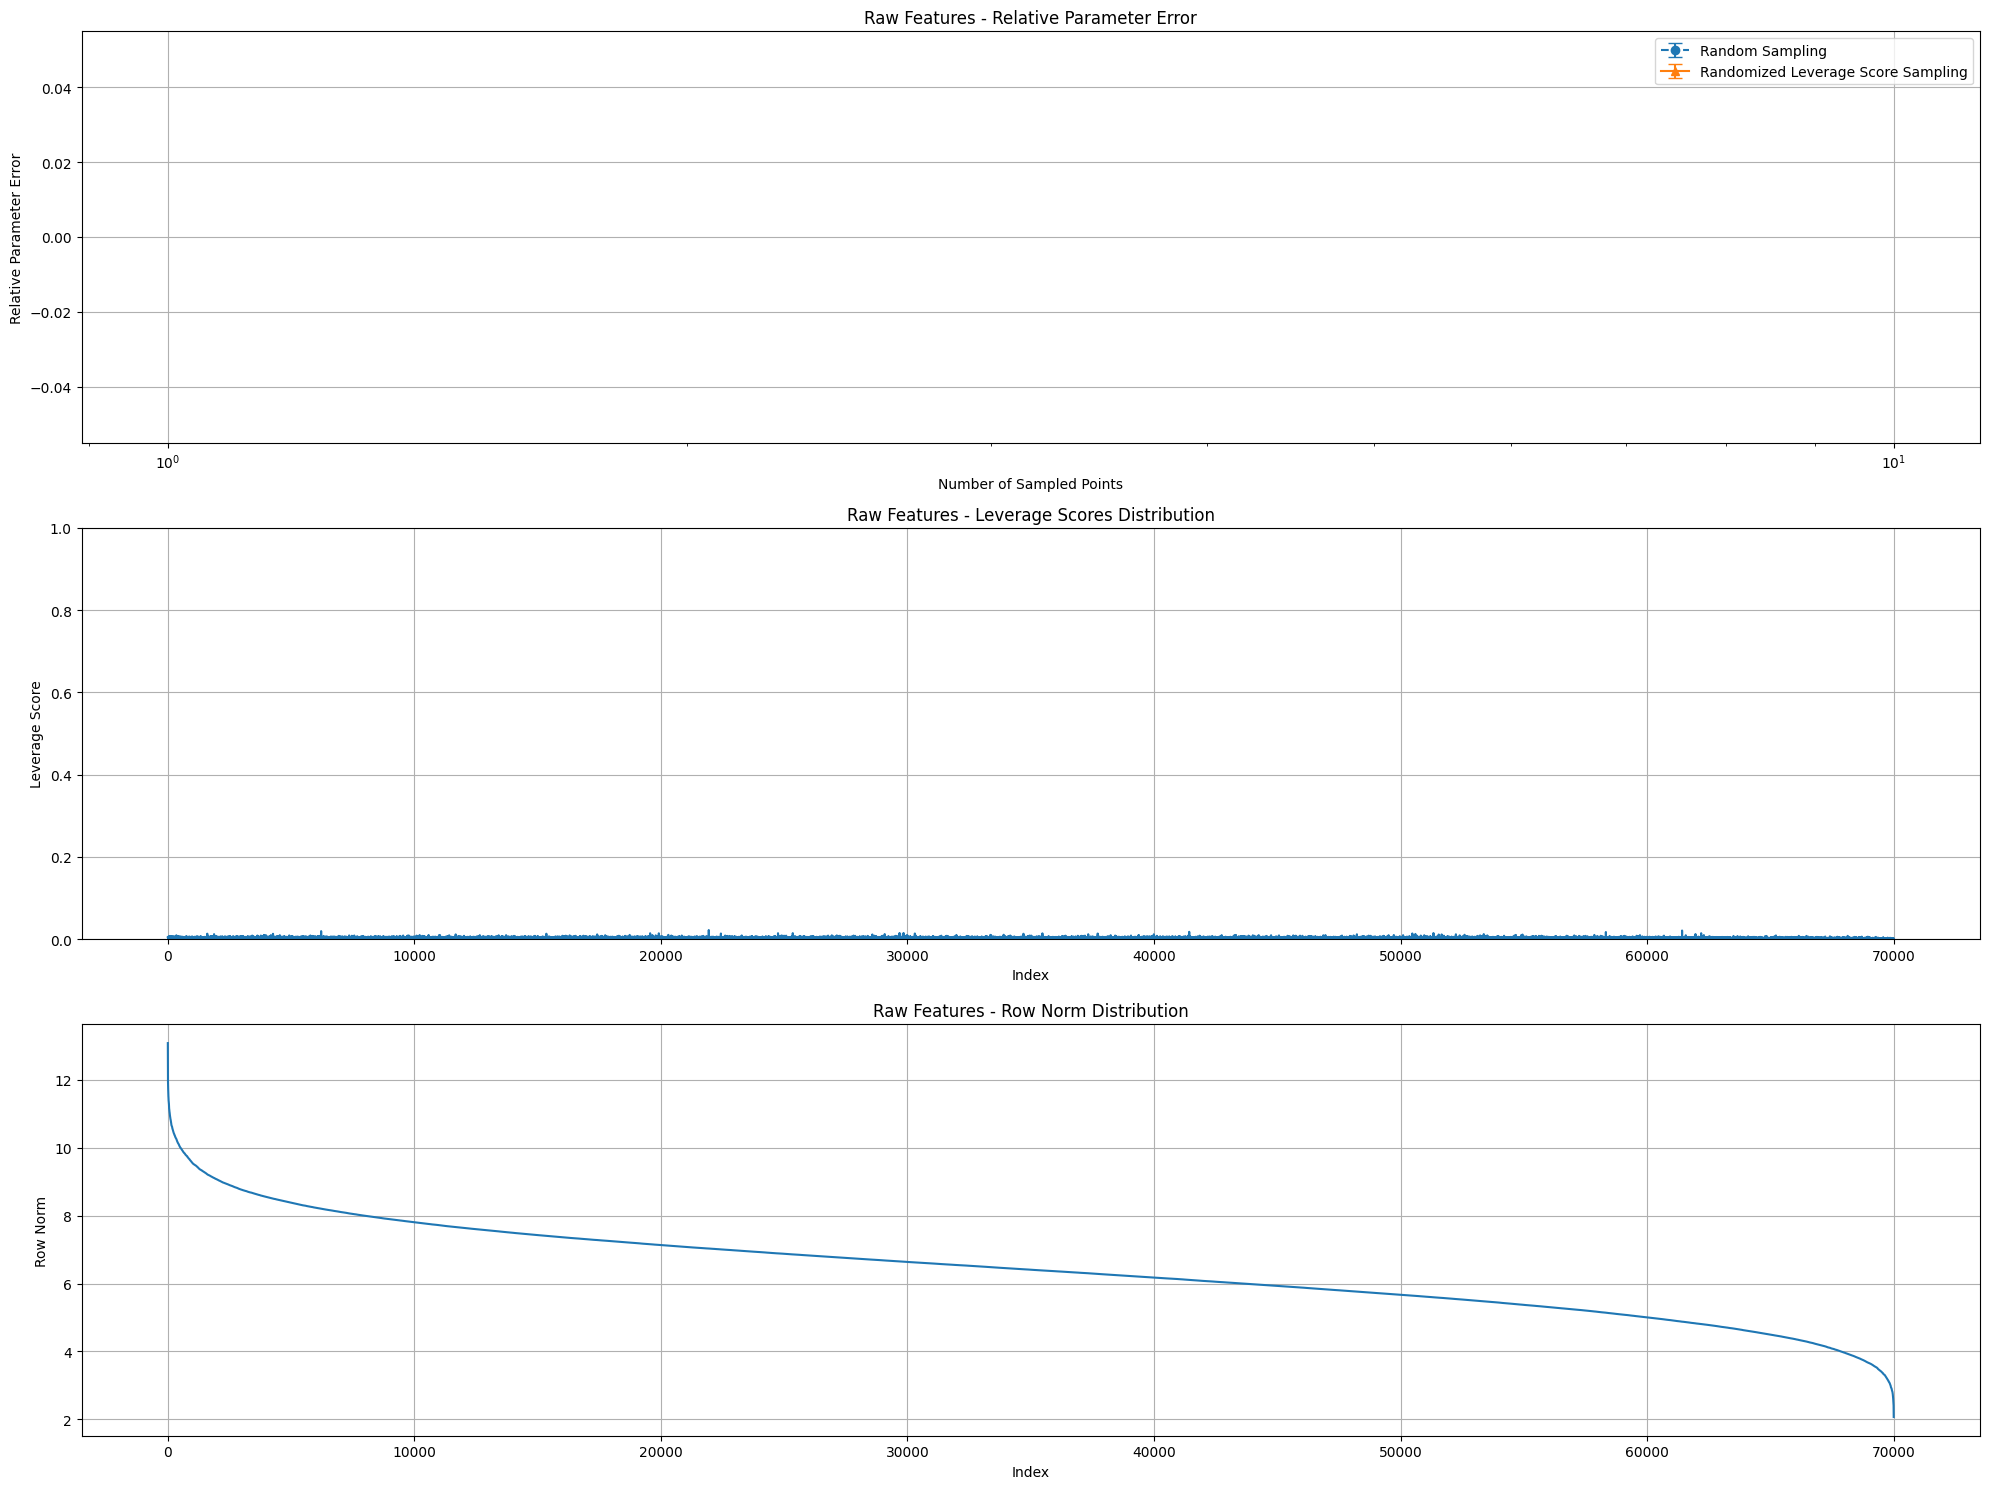

In [26]:
# Plot results in 4 by 3 grid (4 metrics, 3 datasets)
metrics = [
    "parameter_error",
]
extra_metrics = ["Leverage Scores Distribution", "Row Norm Distribution"]
datasets = {
    # "CNN Features": (cnn_x_axis, cnn_data),
    # "RFF Features": (rff_x_axis, rff_data),
    # "ReLU Features": (relu_x_axis, relu_data),
    "Raw Features": (raw_x_axis, raw_data),
}
methods = [
    "random",
    # "leverage",
    "random_leverage",
]
method_labels = {
    "random": "Random Sampling",
    "leverage": "Leverage Score Sampling",
    "random_leverage": "Randomized Leverage Score Sampling",
}
metric_labels = {
    "parameter_error": "Relative Parameter Error",
    "norm_M_pinv": "Frobenius Norm of $M_{TM}^+$",
}
method_styles = {
    "random": "o--",
    "leverage": "s-.",
    "random_leverage": "^-",
}

fig, axes = plt.subplots(
    len(metrics) + len(extra_metrics),
    len(datasets),
    figsize=(20, 5 * (len(metrics) + len(extra_metrics))),
)
print(datasets["Raw Features"])

# print(cnn_data["parameter_error"]["random"])

for col, (dataset_name, (x_axis, data)) in enumerate(datasets.items()):
    for row, metric in enumerate(metrics):
        ax = axes[row]
        for method in methods:
            print("Plotting", dataset_name, metric, method)
            ax.errorbar(
                x_axis,
                data[metric][method]["mean"],
                yerr=data[metric][method]["std"],
                fmt=method_styles[method],
                capsize=5,
                label=method_labels[method],
            )
        ax.set_title(f"{dataset_name} - {metric_labels[metric]}")
        ax.set_xlabel("Number of Sampled Points")
        ax.set_xscale("log")
        ax.set_ylabel(metric_labels[metric])
        # ax.set_yscale("log")
        ax.grid(True)
        if row == 0 and col == 0:
            ax.legend()

    # Plot leverage scores distribution
    ax = axes[len(metrics)]
    if dataset_name == "CNN Features":
        M = mnist_cnn_embedding.float()
    elif dataset_name == "RFF Features":
        M = mnist_rff_features.float()
    else:  # ReLU Features
        M = mnist_relu_features.float()

    row_norms = torch.linalg.norm(M, dim=1).cpu().numpy()
    leverage_scores = (
        (torch.linalg.norm(torch.linalg.qr(M, mode="reduced").Q, dim=1) ** 2)
        .cpu()
        .numpy()
    )
    ax.plot(leverage_scores[np.argsort(row_norms)[::-1]])
    # ax.plot(np.sort(leverage_scores)[::-1])
    ax.set_title(f"{dataset_name} - Leverage Scores Distribution")
    ax.set_xlabel("Index")
    ax.set_ylim(0, 1)
    ax.set_ylabel("Leverage Score")
    ax.grid(True)

    # Plot row norm distribution
    ax = axes[len(metrics) + 1]
    # ax.plot(row_norms[np.argsort(leverage_scores)[::-1]])
    ax.plot(np.sort(row_norms)[::-1])
    ax.set_title(f"{dataset_name} - Row Norm Distribution")
    ax.set_xlabel("Index")
    ax.set_ylabel("Row Norm")
    ax.grid(True)

plt.tight_layout()
plt.savefig("mnist_leverage_vs_uniform.png")
plt.show()

# Question: How does the leverage score distribution relate to the embedding dimension?

We trained the following embedding models on MNIST: `mnist_cnn_Rxxxx.pth`: For various dimensions `xxxx` (10,20,50,100,150,200,250,300,400,500,1000), we trained a CNN on MNIST and extracted the features from the last hidden layer before the output layer.

In [ ]:
import torch
from matplotlib import pyplot as plt

from mnist_cnn import MnistConvNet

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", DEVICE)
dimensions = [10,20,50,100,150,200,250,300,400,500,1000]

fig, axes = plt.subplots(
    3,
    4,
    figsize=(5 * 4, 5 * 3),
)
for i, dimension in enumerate(dimensions):
    model_path = f"models/mnist_cnn_R{dimension}.pth"
    network = MnistConvNet(basis_functions=dimension)
    network.load_state_dict(torch.load(model_path, map_location=DEVICE))
    network.eval()
    mnist_cnn_embedding = embed_dataset(combined_mnist_X, model=network, device=DEVICE, basics_functions=dimension)
    print(f"mnist cnn R{dimension} on", mnist_cnn_embedding.device)
    print(mnist_cnn_embedding.shape)
    leverage_scores = (
        (torch.linalg.norm(torch.linalg.qr(mnist_cnn_embedding.float(), mode="reduced").Q, dim=1) ** 2)
        .cpu()
        .numpy()
    )
    ax = axes[i // 4, i % 4]
    ax.plot(np.sort(leverage_scores)[::-1])
    ax.set_title(f"Dimension {dimension}")
    ax.set_xlabel("Index")
    ax.set_xscale("log")
    ax.set_ylabel("Leverage Score")
    ax.grid(True)
plt.tight_layout()
plt.savefig("mnist_leverage_scores_by_dimension.png")

## CIFAR-10

The CIFAR-10 dataset consists of 60,000 images in color with a resolution of 32x32 pixels, divided into 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). This gives us a 60,000 x 32 x 32 x 3 = 60,000 x 3072 data matrix.

In [ ]:
import torch
from torchvision.datasets import CIFAR10

from cifar_cnn import (
    BiggestCifarConvNet,
    CifarConvNet,
    BASIS_FUNCTIONS,
    BiggerCifarConvNet,
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cifar_images = (
    torch.tensor(CIFAR10(root="./data", train=True, download=True).data)
    .to(DEVICE)
    .permute(0, 3, 1, 2)
    .float()
    / 255.0
)
cifar_labels = torch.tensor(
    CIFAR10(root="./data", train=True, download=True).targets, device=DEVICE
)
test_cifar_images = (
    torch.tensor(CIFAR10(root="./data", train=False, download=True).data)
    .to(DEVICE)
    .permute(0, 3, 1, 2)
    .float()
    / 255.0
)
test_cifar_labels = torch.tensor(
    CIFAR10(root="./data", train=False, download=True).targets, device=DEVICE
)
combined_cifar_images = torch.cat([cifar_images, test_cifar_images], dim=0)
combined_cifar_labels = torch.cat([cifar_labels, test_cifar_labels], dim=0)


network = CifarConvNet()
network.load_state_dict(torch.load("models/cifar_cnn.pth", map_location=DEVICE))
network.eval()

bigger_network = BiggerCifarConvNet()
bigger_network.load_state_dict(
    torch.load("models/cifar_bigger_cnn.pth", map_location=DEVICE)
)
bigger_network.eval()

biggest_network = BiggestCifarConvNet()
biggest_network.load_state_dict(
    torch.load("models/cifar_biggest_cnn.pth", map_location=DEVICE)
)
biggest_network.eval()


def verify_cifar_cnn(model, device):
    model.to(device)
    correct = 0
    total = 0
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(test_cifar_images, test_cifar_labels),
        batch_size=256,
        shuffle=False,
        num_workers=2,
    )
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds: torch.Tensor = model(xb)
            correct += (preds.argmax(dim=1) == yb).sum().item()
            total += yb.size(0)
    print(f"  Test accuracy: {correct / total:.4f}")


# print("Verifying CIFAR-10 CNN model accuracy:")
# verify_cifar_cnn(network, DEVICE)
# print("Verifying Bigger CIFAR-10 CNN model accuracy:")
# verify_cifar_cnn(bigger_network, DEVICE)
# print("Verifying Biggest CIFAR-10 CNN model accuracy:")
# verify_cifar_cnn(biggest_network, DEVICE)

In [ ]:
import numpy as np

cifar_cnn_embedding = embed_dataset(combined_cifar_images, model=network, device=DEVICE)
print("cifar cnn on", cifar_cnn_embedding.device)
print(cifar_cnn_embedding.shape)

cifar_bigger_cnn_embedding = embed_dataset(
    combined_cifar_images, model=bigger_network, device=DEVICE
)
print("cifar bigger cnn on", cifar_bigger_cnn_embedding.device)
print(cifar_bigger_cnn_embedding.shape)

cifar_biggest_cnn_embedding = embed_dataset(
    combined_cifar_images, model=biggest_network, device=DEVICE
)
print("cifar biggest cnn on", cifar_biggest_cnn_embedding.device)
print(cifar_biggest_cnn_embedding.shape)

cifar_rff_features = rff_features(combined_cifar_images, features=200)
print("cifar rff on", cifar_rff_features.device)
print(cifar_rff_features.shape)

cifar_relu_features = relu_features(combined_cifar_images, features=200)
print("cifar relu on", cifar_relu_features.device)
print(cifar_relu_features.shape)

In [ ]:
labels = torch.nn.functional.one_hot(
    combined_cifar_labels,
    num_classes=10,
).to(DEVICE, dtype=torch.float32)

SAMPLE_POINTS = labels.shape[0]

SAMPLE_POINT_STEP = 1000
SAMPLE_POINT_LOG_STEP = 0.1

X_AXIS = [
    int(10 ** (SAMPLE_POINT_LOG_STEP * i))
    for i in range(10, int(np.log10(SAMPLE_POINTS) / SAMPLE_POINT_LOG_STEP) + 1)
]


TRIALS = 50
REGULARIZER = 1e-10

print("Simulating CNN features...")
print("-----------------------")
cnn_x_axis, cnn_data = simulation(
    X_AXIS,
    cifar_cnn_embedding.float(),
    labels,
    trials=TRIALS,
    regularize=REGULARIZER,
)
print("Simulating Bigger CNN features...")
print("-----------------------")
bigger_cnn_x_axis, bigger_cnn_data = simulation(
    X_AXIS,
    cifar_bigger_cnn_embedding.float(),
    labels,
    trials=TRIALS,
    regularize=REGULARIZER,
)
print("Simulating Biggest CNN features...")
print("-----------------------")
biggest_cnn_x_axis, biggest_cnn_data = simulation(
    X_AXIS,
    cifar_biggest_cnn_embedding.float(),
    labels,
    trials=TRIALS,
    regularize=REGULARIZER,
)
print("Simulating RFF features...")
print("-----------------------")
rff_x_axis, rff_data = simulation(
    X_AXIS,
    cifar_rff_features.float(),
    labels,
    trials=TRIALS,
    regularize=REGULARIZER,
)
print("Simulating ReLU features...")
print("-----------------------")
relu_x_axis, relu_data = simulation(
    X_AXIS,
    cifar_relu_features.float(),
    labels,
    trials=TRIALS,
    regularize=REGULARIZER,
)

In [ ]:
from matplotlib import pyplot as plt

metrics = [
    "parameter_error",
]
extra_metrics = ["Leverage Scores Distribution"]
datasets = {
    "CNN Features": (cnn_x_axis, cnn_data),
    "Bigger CNN Features": (bigger_cnn_x_axis, bigger_cnn_data),
    "Biggest CNN Features": (biggest_cnn_x_axis, biggest_cnn_data),
    "RFF Features": (rff_x_axis, rff_data),
    "ReLU Features": (relu_x_axis, relu_data),
}
embeddings = {
    "CNN Features": cifar_cnn_embedding,
    "Bigger CNN Features": cifar_bigger_cnn_embedding,
    "Biggest CNN Features": cifar_biggest_cnn_embedding,
    "RFF Features": cifar_rff_features,
    "ReLU Features": cifar_relu_features,
}
methods = ["random", "leverage", "random_leverage"]
method_labels = {
    "random": "Random Sampling",
    "leverage": "Leverage Score Sampling",
    "random_leverage": "Randomized Leverage Score Sampling",
}
metric_labels = {
    "parameter_error": "Relative Parameter Error",
    "norm_M_pinv": "Frobenius Norm of $M_{TM}^+$",
}
method_styles = {
    "random": "o--",
    "leverage": "s-.",
    "random_leverage": "^-",
}

fig, axes = plt.subplots(
    len(metrics) + len(extra_metrics),
    len(datasets),
    figsize=(10 * len(datasets), 5 * (len(metrics) + len(extra_metrics))),
)

print(cnn_data["parameter_error"]["random"])

for col, (dataset_name, (x_axis, data)) in enumerate(datasets.items()):
    for row, metric in enumerate(metrics):
        ax = axes[row, col]
        for method in methods:
            ax.errorbar(
                x_axis,
                data[metric][method]["mean"],
                yerr=data[metric][method]["std"],
                fmt=method_styles[method],
                capsize=10,
                label=method_labels[method],
            )
        ax.set_title(f"{dataset_name} - {metric_labels[metric]}")
        ax.set_xlabel("Number of Sampled Points")
        ax.set_xscale("log")
        ax.set_ylabel(metric_labels[metric])
        ax.set_ylim(bottom=1e-1)
        ax.set_yscale("log")
        ax.grid(True)
        if row == 0 and col == 0:
            ax.legend()

    # Plot leverage scores distribution
    ax = axes[len(metrics), col]
    M = embeddings[dataset_name]

    leverage_scores = (
        (torch.linalg.norm(torch.linalg.qr(M, mode="reduced").Q, dim=1) ** 2)
        .cpu()
        .numpy()
    )
    ax.plot(np.sort(leverage_scores)[::-1])
    ax.set_title(f"{dataset_name} - Leverage Scores Distribution")
    ax.set_xlabel("Index")
    ax.set_xscale("log")
    ax.set_ylabel("Leverage Score")
    ax.grid(True)

plt.tight_layout()
plt.savefig("cifar10_leverage_vs_uniform.png")
plt.show()